# Movement Models Analyst


In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pygris.data import get_lodes
from datetime import datetime, timedelta
from pygris import block_groups, school_districts
import geopandas as gpd

import numpy as np
import matplotlib.gridspec as gridspec
from epymorph import *
from epymorph.adrio import acs5, us_tiger
from epymorph.plots import map_data_by_block_group
from epymorph.geography.us_census import BlockGroupScope


# Movement Models
1. Centroids
2. Cemtroids: Recaluation
3. Data for Good
4. LODES Communter Matrix
5. School Communter Matrix

In [4]:
STATE = "AZ"
COUNTY = "Maricopa"
YEAR = 2019
census_block_groups = block_groups(state=STATE, county=COUNTY, year=YEAR, cache=True)

Using FIPS code '04' for input 'AZ'
Using FIPS code '013' for input 'Maricopa'


In [5]:
scope = BlockGroupScope.in_counties(["04013"], year=2019)

print(f"nodes: {scope.nodes}")

nodes: 2505


# Centroid Movement Model
A gravity based model 

In [16]:
Centroid_rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["centroids"](),
    scope=scope,
    params={
        "beta": 0.35,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 10.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 50),
    init=init.SingleLocation(location=0, seed_size=5),
)

Centroid_sim = BasicSimulator(Centroid_rume)
with sim_messaging():
    Centroid_output = Centroid_sim.run()

ADRIO Population fetching `gpm:all::mm::population`... done (2.171 seconds)
ADRIO GeometricCentroid fetching `gpm:all::mm::centroid`... done (71.034 seconds)
ADRIO Population fetching `gpm:all::init::population`... done (0.000 seconds)
ADRIO Name fetching `meta::geo::label`... done (0.110 seconds)
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-02-20 (50 days)
• 2505 geo nodes
|####################| 100% 
Runtime: 155.284s


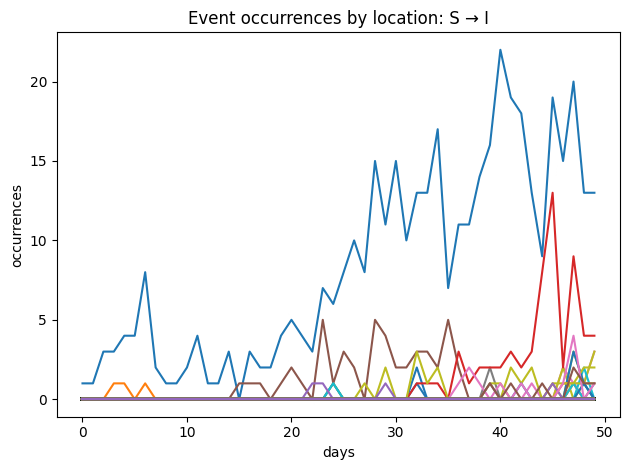

In [17]:
EVENT_S_TO_I = Centroid_rume.ipm.event_by_name("S->I")

plot_event(Centroid_output, event_idx=EVENT_S_TO_I)

day_of_peak_infection = np.array(
    [
        # argmax gives us an index, but the index is equal to the tau step index
        # so just need to floor-div by number of tau steps to get day
        float(np.argmax(Centroid_output.incidence[:, n, EVENT_S_TO_I]))
        // Centroid_output.dim.tau_steps
        for n in range(scope.nodes)
    ]
)

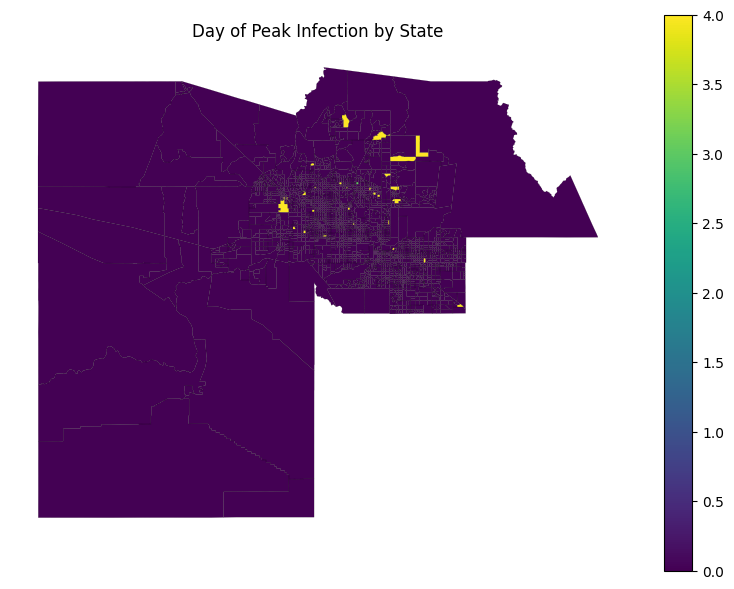

In [24]:
map_data_by_block_group(
    scope=scope,
    data=day_of_peak_infection,
    title="Day of Peak Infection by State",
    vmin=0,
    vmax=Centroid_output.dim.compartments,
    cmap="viridis",
    year=2019,
)

# NASA: Gridded Population

In [ ]:
Centroid_rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["centroids"](),
    scope=scope,
    params={
        "beta": 0.35,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 10.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 50),
    init=init.SingleLocation(location=0, seed_size=5),
)

Centroid_sim = BasicSimulator(Centroid_rume)
with sim_messaging():
    Centroid_output = Centroid_sim.run()

# Data for Good


In [7]:
dir = "/Users/alexandernez/Desktop/Github/Epymorph_vignettes/scratch/Data_for_good/movement-distribution"
month = "May_2024"

Movement_month = os.path.join(dir, month)

files = os.listdir(Movement_month)

In [8]:
County = " Maricopa"

start_date = datetime.strptime("2023-07-24", "%Y-%m-%d")
end_date = datetime.strptime("2024-05-22", "%Y-%m-%d")

required_categories = ["0", "(0, 10)", "[10, 100)", "100+"]


def read_and_filter_data(file_path, county_name):
    data = pd.read_csv(file_path)
    return data[data["gadm_name"] == county_name]


all_data = pd.DataFrame()

current_date = start_date
while current_date <= end_date:
    month_folder = current_date.strftime("%B_%Y")
    day_file = f"{current_date.strftime('%Y-%m-%d')}.csv"

    file_path = os.path.join(dir, month_folder, day_file)

    if os.path.exists(file_path):
        daily_data = read_and_filter_data(file_path, "Maricopa")
        all_data = pd.concat([all_data, daily_data])

    current_date += timedelta(days=1)

grouped_data = (
    all_data.groupby(["ds", "home_to_ping_distance_category"])[
        "distance_category_ping_fraction"
    ]
    .mean()
    .reset_index()
)
pivot_data = grouped_data.pivot(
    index="ds",
    columns="home_to_ping_distance_category",
    values="distance_category_ping_fraction",
).reset_index()

for category in required_categories:
    if category not in pivot_data.columns:
        pivot_data[category] = 0

pivot_data = pivot_data[["ds"] + required_categories]

pivot_data.to_csv(
    os.path.join(dir, f"{County}_{start_date}_{end_date}_movement_data.csv"),
    index=False,
)

In [9]:
print("Highest and Lowest Travel Days by Category:")

for category in required_categories:
    highest_idx = pivot_data[category].idxmax()
    lowest_idx = pivot_data[category].idxmin()

    highest_day = pivot_data.loc[highest_idx, "ds"]
    highest_value = pivot_data.loc[highest_idx, category]

    lowest_day = pivot_data.loc[lowest_idx, "ds"]
    lowest_value = pivot_data.loc[lowest_idx, category]

    print(f"\nCategory: {category}")
    print(f"  Highest Travel Day: {highest_day} (Value: {highest_value:.4f})")
    print(f"  Lowest Travel Day: {lowest_day} (Value: {lowest_value:.4f})")


Highest and Lowest Travel Days by Category:

Category: 0
  Highest Travel Day: 2024-01-01 (Value: 0.4204)
  Lowest Travel Day: 2023-10-20 (Value: 0.3560)

Category: (0, 10)
  Highest Travel Day: 2024-01-21 (Value: 0.5027)
  Lowest Travel Day: 2023-10-09 (Value: 0.4850)

Category: [10, 100)
  Highest Travel Day: 2023-10-20 (Value: 0.1397)
  Lowest Travel Day: 2024-01-01 (Value: 0.0636)

Category: 100+
  Highest Travel Day: 2023-09-04 (Value: 0.0253)
  Lowest Travel Day: 2024-01-30 (Value: 0.0078)


In [10]:
holidays = [
    "2023-09-04",  # Labor Day
    "2023-11-23",  # Thanksgiving
    "2023-12-25",  # Christmas
    "2024-01-01",  # New Year
    "2024-05-27",  # Memorial Day
]

holiday_dates = [datetime.strptime(date, "%Y-%m-%d") for date in holidays]

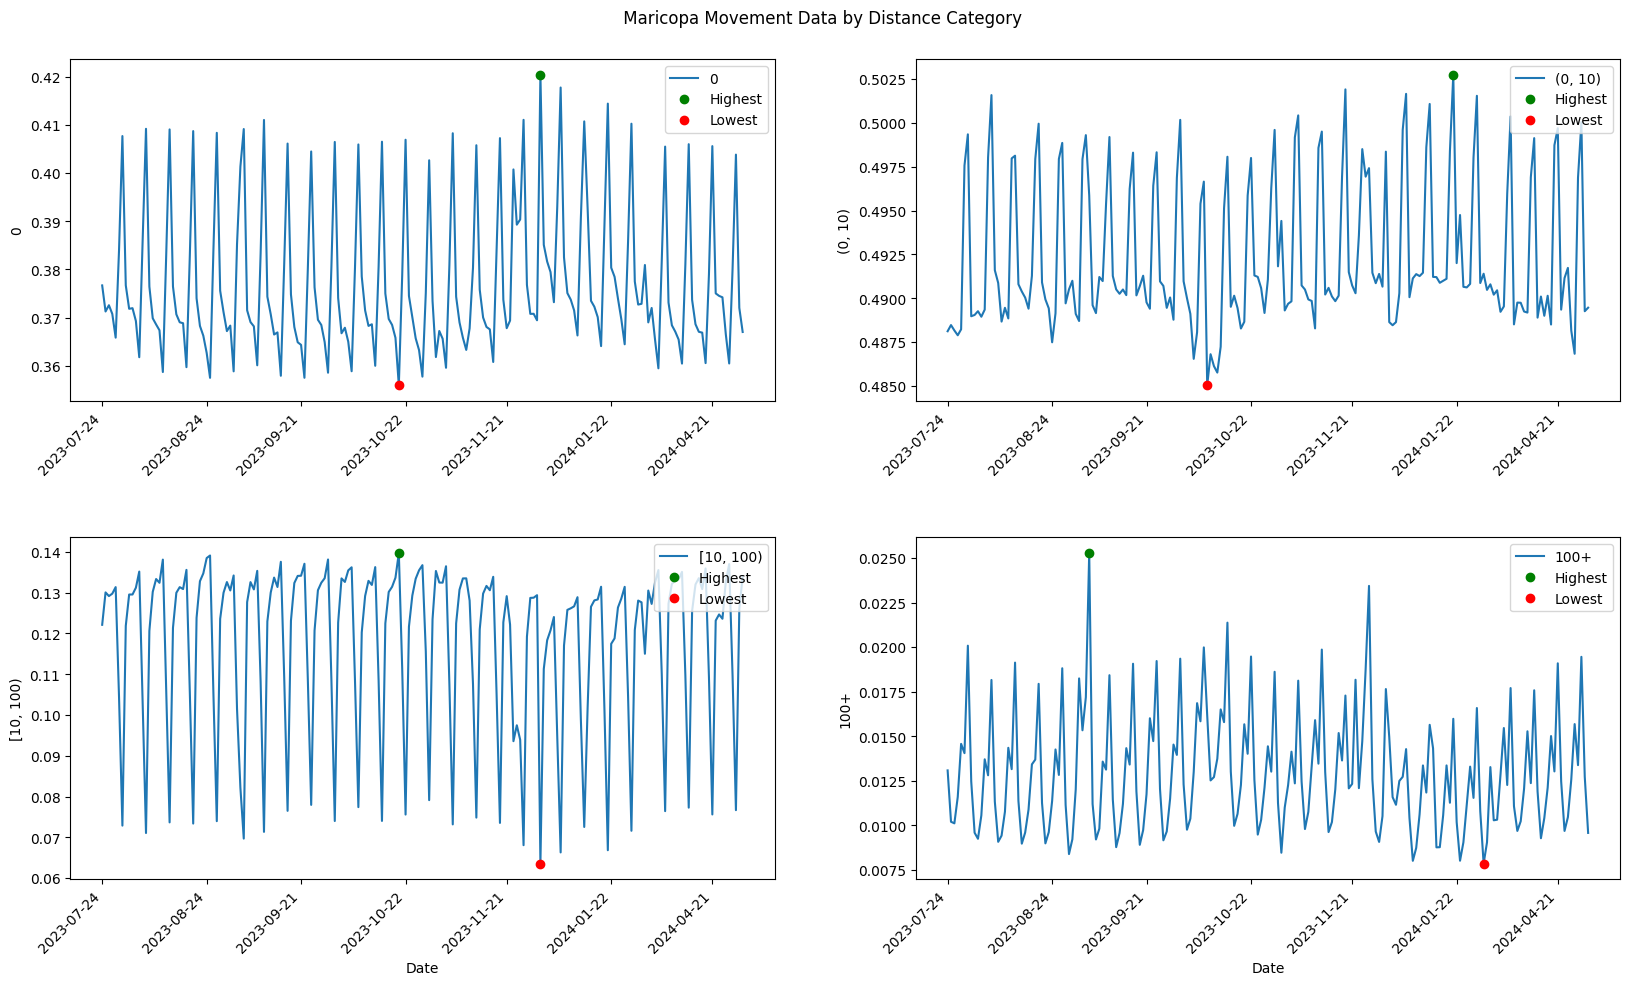

In [11]:
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.4)

x = pivot_data["ds"]

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x, pivot_data[required_categories[0]], label=required_categories[0])
ax1.set_ylabel(required_categories[0])
ax1.legend(loc="upper right")

ax2 = fig.add_subplot(gs[0, 1], sharex=ax1)
ax2.plot(x, pivot_data[required_categories[1]], label=required_categories[1])
ax2.set_ylabel(required_categories[1])
ax2.legend(loc="upper right")

ax3 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax3.plot(x, pivot_data[required_categories[2]], label=required_categories[2])
ax3.set_ylabel(required_categories[2])
ax3.legend(loc="upper right")
ax3.set_xlabel("Date")

ax4 = fig.add_subplot(gs[1, 1], sharex=ax1)
ax4.plot(x, pivot_data[required_categories[3]], label=required_categories[3])
ax4.set_ylabel(required_categories[3])
ax4.legend(loc="upper right")
ax4.set_xlabel("Date")

for i, ax in enumerate([ax1, ax2, ax3, ax4]):
    category = required_categories[i]
    highest_idx = pivot_data[category].idxmax()
    lowest_idx = pivot_data[category].idxmin()

    ax.plot(
        pivot_data.loc[highest_idx, "ds"],
        pivot_data.loc[highest_idx, category],
        "go",
        label="Highest",
    )
    ax.plot(
        pivot_data.loc[lowest_idx, "ds"],
        pivot_data.loc[lowest_idx, category],
        "ro",
        label="Lowest",
    )

    for holiday in holiday_dates:
        if holiday in pivot_data["ds"].values:
            holiday_value = pivot_data.loc[
                pivot_data["ds"] == holiday, category
            ].values[0]
            ax.plot(
                holiday,
                holiday_value,
                "ko",
                label="Holiday" if holiday == holiday_dates[0] else "",
                markersize=5,
            )

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc="upper right")

    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

fig.suptitle(f"{County} Movement Data by Distance Category")

plt.subplots_adjust(top=0.93)

plt.show()

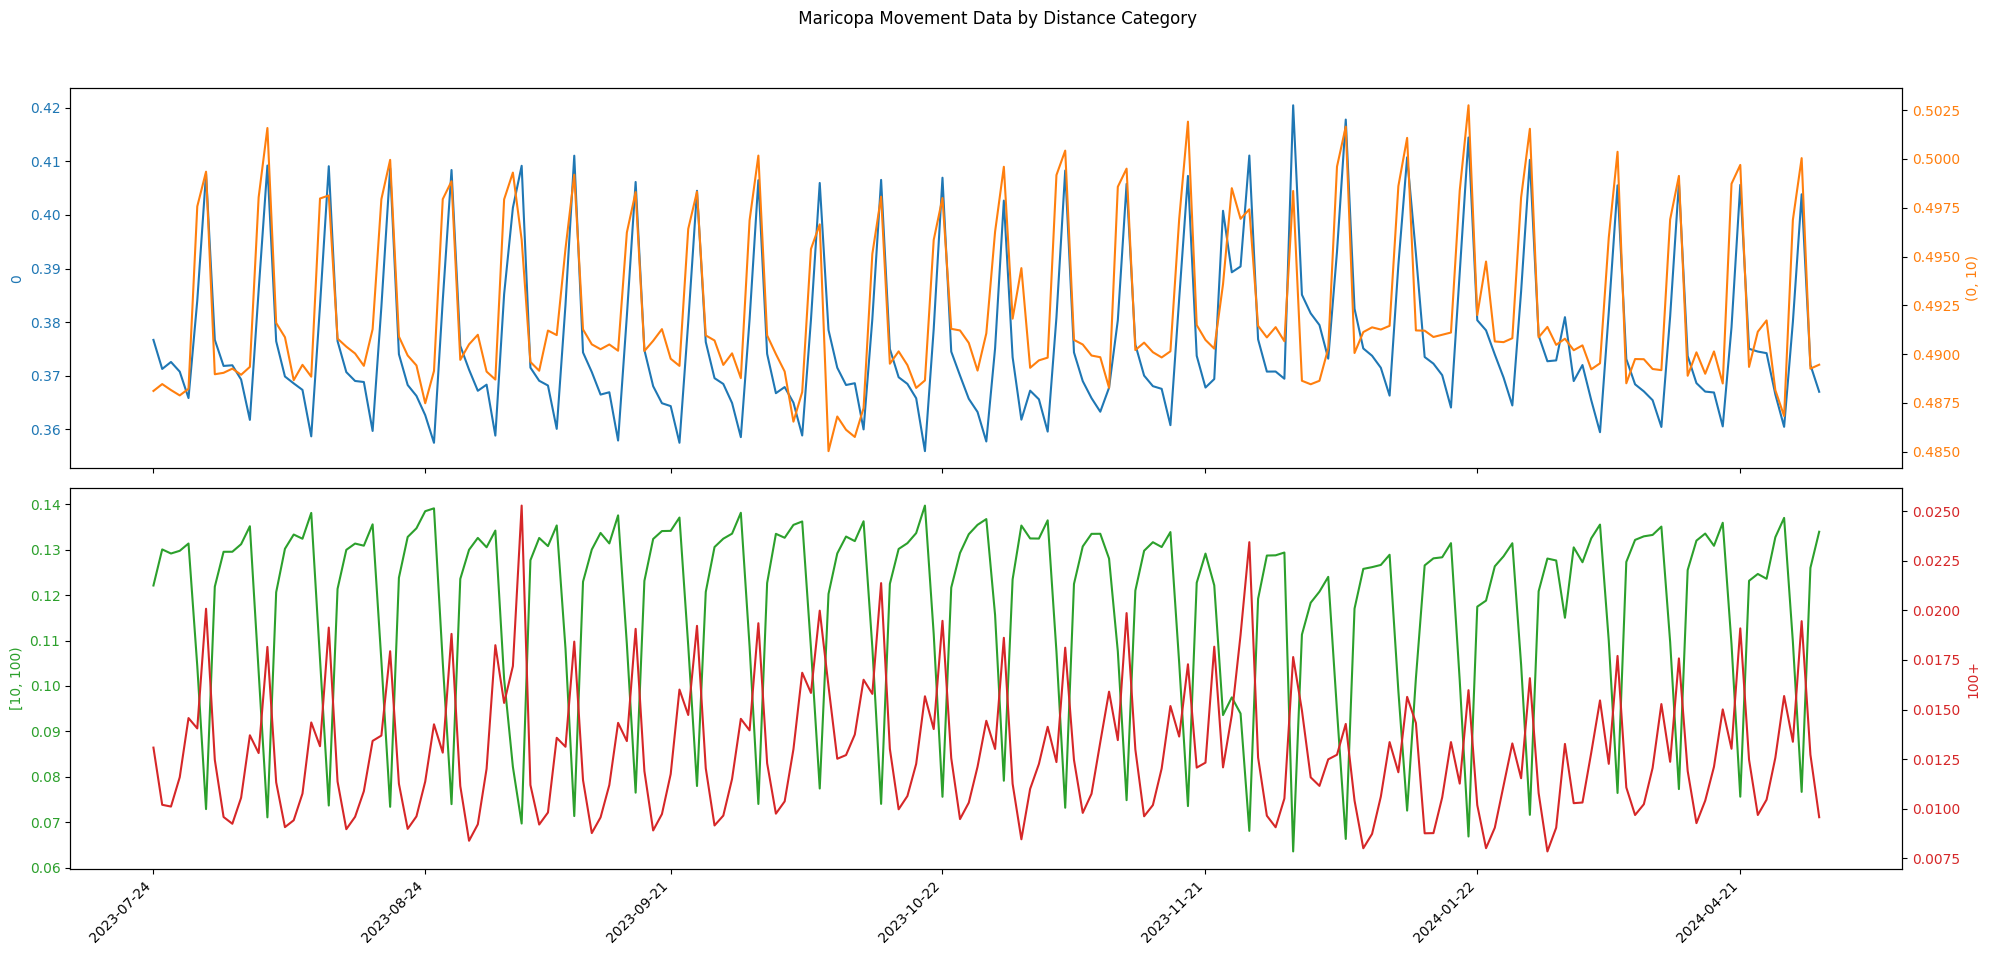

In [28]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
x = pivot_data["ds"]

ax1.plot(
    x,
    pivot_data[required_categories[0]],
    label=required_categories[0],
    color="tab:blue",
)
ax1.set_ylabel(required_categories[0], color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax1b = ax1.twinx()
ax1b.plot(
    x,
    pivot_data[required_categories[1]],
    label=required_categories[1],
    color="tab:orange",
)
ax1b.set_ylabel(required_categories[1], color="tab:orange")
ax1b.tick_params(axis="y", labelcolor="tab:orange")

for holiday in holiday_dates:
    if holiday in pivot_data["ds"].values:
        val_left = pivot_data.loc[
            pivot_data["ds"] == holiday, required_categories[0]
        ].values[0]
        val_right = pivot_data.loc[
            pivot_data["ds"] == holiday, required_categories[1]
        ].values[0]
        ax1.plot(
            holiday,
            val_left,
            "ko",
            label="Holiday" if holiday == holiday_dates[0] else "",
            markersize=5,
        )
        ax1b.plot(
            holiday,
            val_right,
            "ko",
            label="Holiday" if holiday == holiday_dates[0] else "",
            markersize=5,
        )

ax2.plot(
    x,
    pivot_data[required_categories[2]],
    label=required_categories[2],
    color="tab:green",
)
ax2.set_ylabel(required_categories[2], color="tab:green")
ax2.tick_params(axis="y", labelcolor="tab:green")

ax2b = ax2.twinx()
ax2b.plot(
    x, pivot_data[required_categories[3]], label=required_categories[3], color="tab:red"
)
ax2b.set_ylabel(required_categories[3], color="tab:red")
ax2b.tick_params(axis="y", labelcolor="tab:red")

for holiday in holiday_dates:
    if (pivot_data["ds"] == holiday).any():
        val_left = pivot_data.loc[
            pivot_data["ds"] == holiday, required_categories[0]
        ].values[0]
        val_right = pivot_data.loc[
            pivot_data["ds"] == holiday, required_categories[1]
        ].values[0]
        ax1.plot(
            holiday,
            val_left,
            "ko",
            label="Holiday" if holiday == holiday_dates[0] else "",
            markersize=5,
        )
        ax1b.plot(
            holiday,
            val_right,
            "ko",
            label="Holiday" if holiday == holiday_dates[0] else "",
            markersize=5,
        )


ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right")

fig.suptitle(f"{County} Movement Data by Distance Category")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Low Travel Time


In [12]:
LTT_rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["dynamic"](),
    scope=scope,
    params={
        "beta": 0.35,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 5.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2023-10-13", 150),
    init=init.SingleLocation(location=0, seed_size=5),
)

LTT_sim = BasicSimulator(LTT_rume)
with sim_messaging():
    LTT_output = LTT_sim.run()

ADRIO Population fetching `gpm:all::mm::population`... done (2.072 seconds)
ADRIO GeometricCentroid fetching `gpm:all::mm::centroid`... done (73.399 seconds)
ADRIO Population fetching `gpm:all::init::population`... done (0.000 seconds)
ADRIO Name fetching `meta::geo::label`... done (0.112 seconds)
Running simulation (BasicSimulator):
• 2023-10-13 to 2024-03-11 (150 days)
• 2505 geo nodes
|####################| 100% 
Runtime: 518.931s


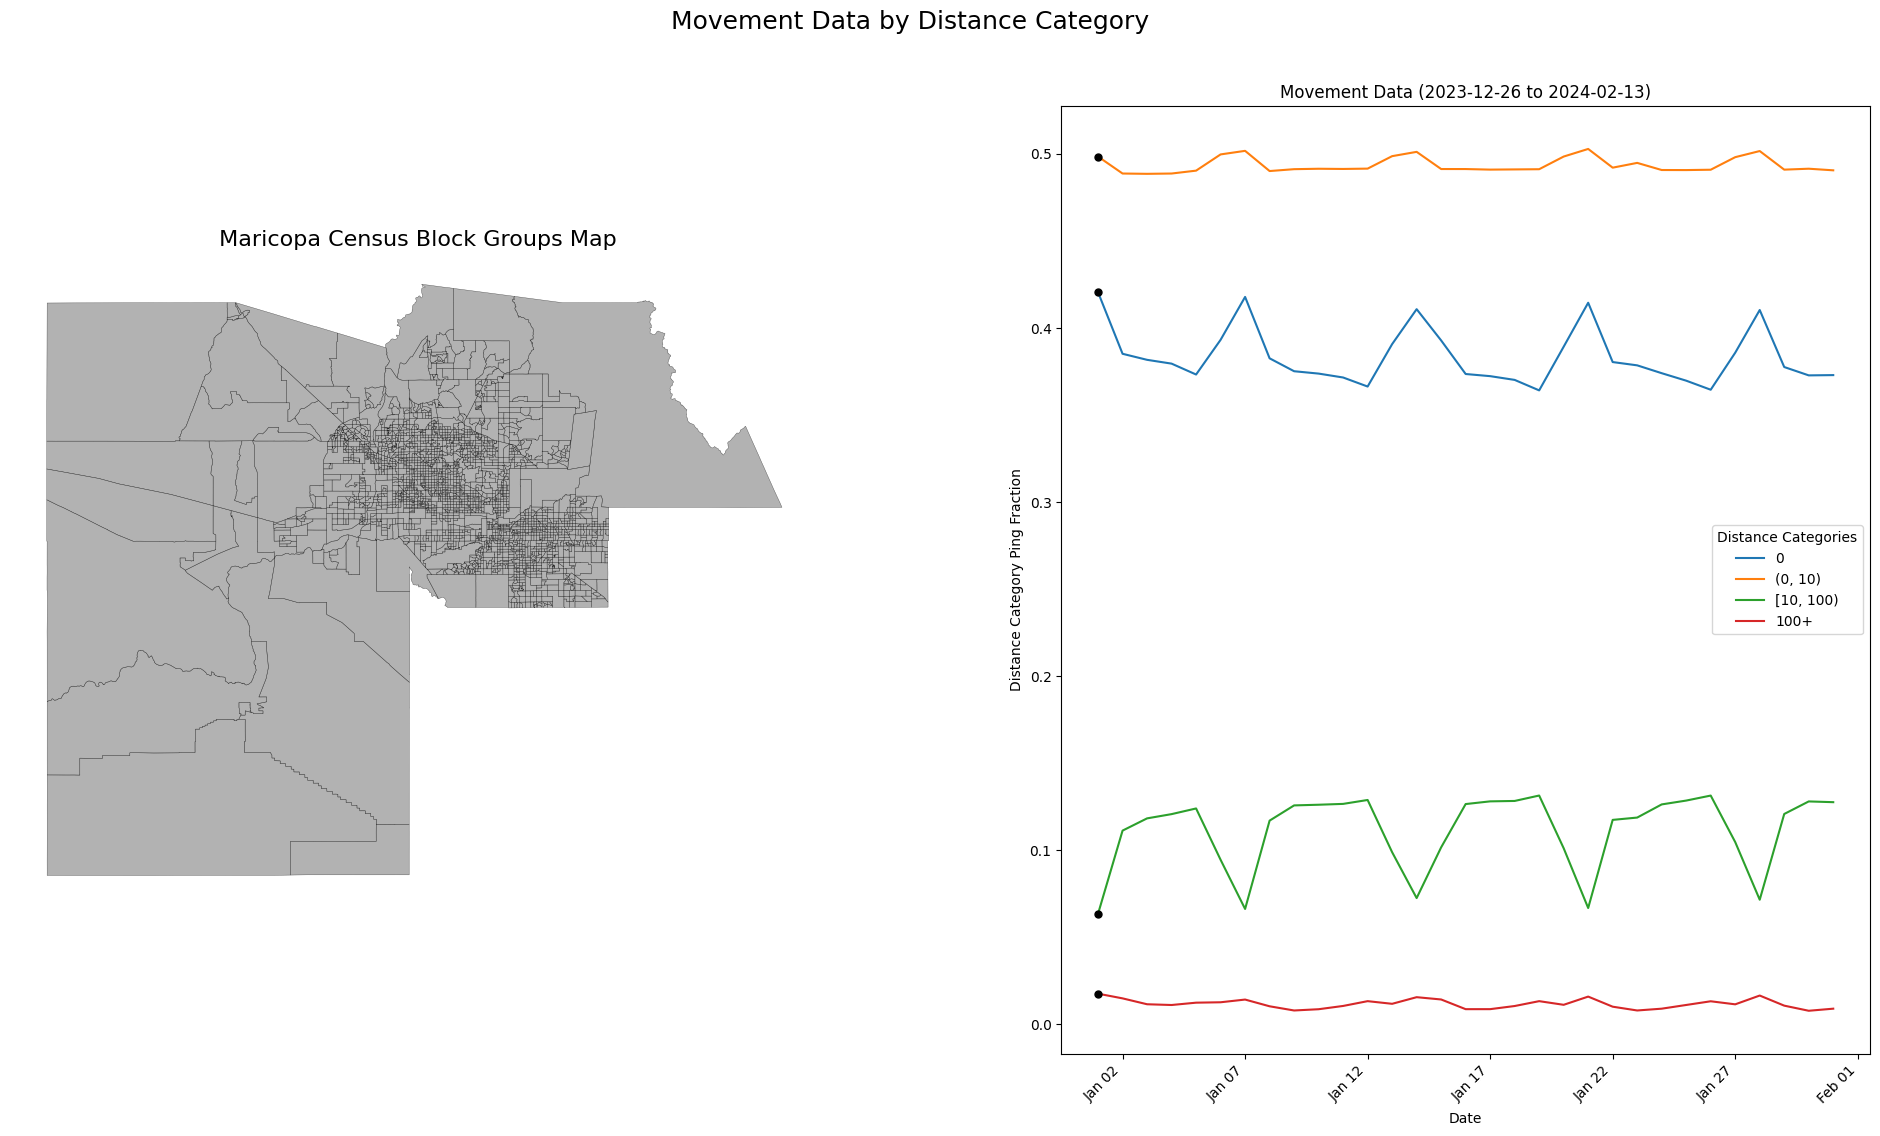

In [14]:
pivot_data["ds"] = pd.to_datetime(pivot_data["ds"], errors='coerce')
pivot_data = pivot_data.dropna(subset=["ds"])

start_date_graph = pd.to_datetime("2023-12-26")
end_date_graph = start_date_graph + pd.Timedelta(days=49)
filtered_pivot_data = pivot_data[
    (pivot_data["ds"] >= start_date_graph) & (pivot_data["ds"] <= end_date_graph)
]

filtered_holiday_dates = [d for d in holiday_dates if start_date_graph <= d <= end_date_graph]

fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)

ax_map = fig.add_subplot(gs[0])
census_block_groups.plot(
    linewidth=0.3, ax=ax_map, edgecolor="black", color="grey", alpha=0.6
)
ax_map.axis("off")
ax_map.set_title(f"{County} Census Block Groups Map", fontsize=16)


ax_graph = fig.add_subplot(gs[1])
x = filtered_pivot_data["ds"]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, category in enumerate(required_categories):
    ax_graph.plot(x, filtered_pivot_data[category], label=category, color=colors[i])

for holiday in filtered_holiday_dates:
    for i, category in enumerate(required_categories):
        holiday_value = filtered_pivot_data.loc[filtered_pivot_data["ds"] == holiday, category].values
        if len(holiday_value) > 0:
            ax_graph.plot(holiday, holiday_value[0], "ko", markersize=5)

ax_graph.set_ylabel("Distance Category Ping Fraction")
ax_graph.set_xlabel("Date")
ax_graph.legend(title="Distance Categories")
ax_graph.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax_graph.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax_graph.get_xticklabels(), rotation=45, ha="right")
ax_graph.set_title(f"Movement Data ({start_date_graph.date()} to {end_date_graph.date()})")

fig.suptitle(f"Movement Data by Distance Category", fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

## High Travel Time


In [ ]:
HTT_rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["dynamic"](),
    scope=scope,
    params={
        "beta": 0.35,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 10.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2023-08-29", 150),
    init=init.SingleLocation(location=0, seed_size=5),
)

HTT_sim = BasicSimulator(HTT_rume)
with sim_messaging():
    HTT_output = HTT_sim.run()

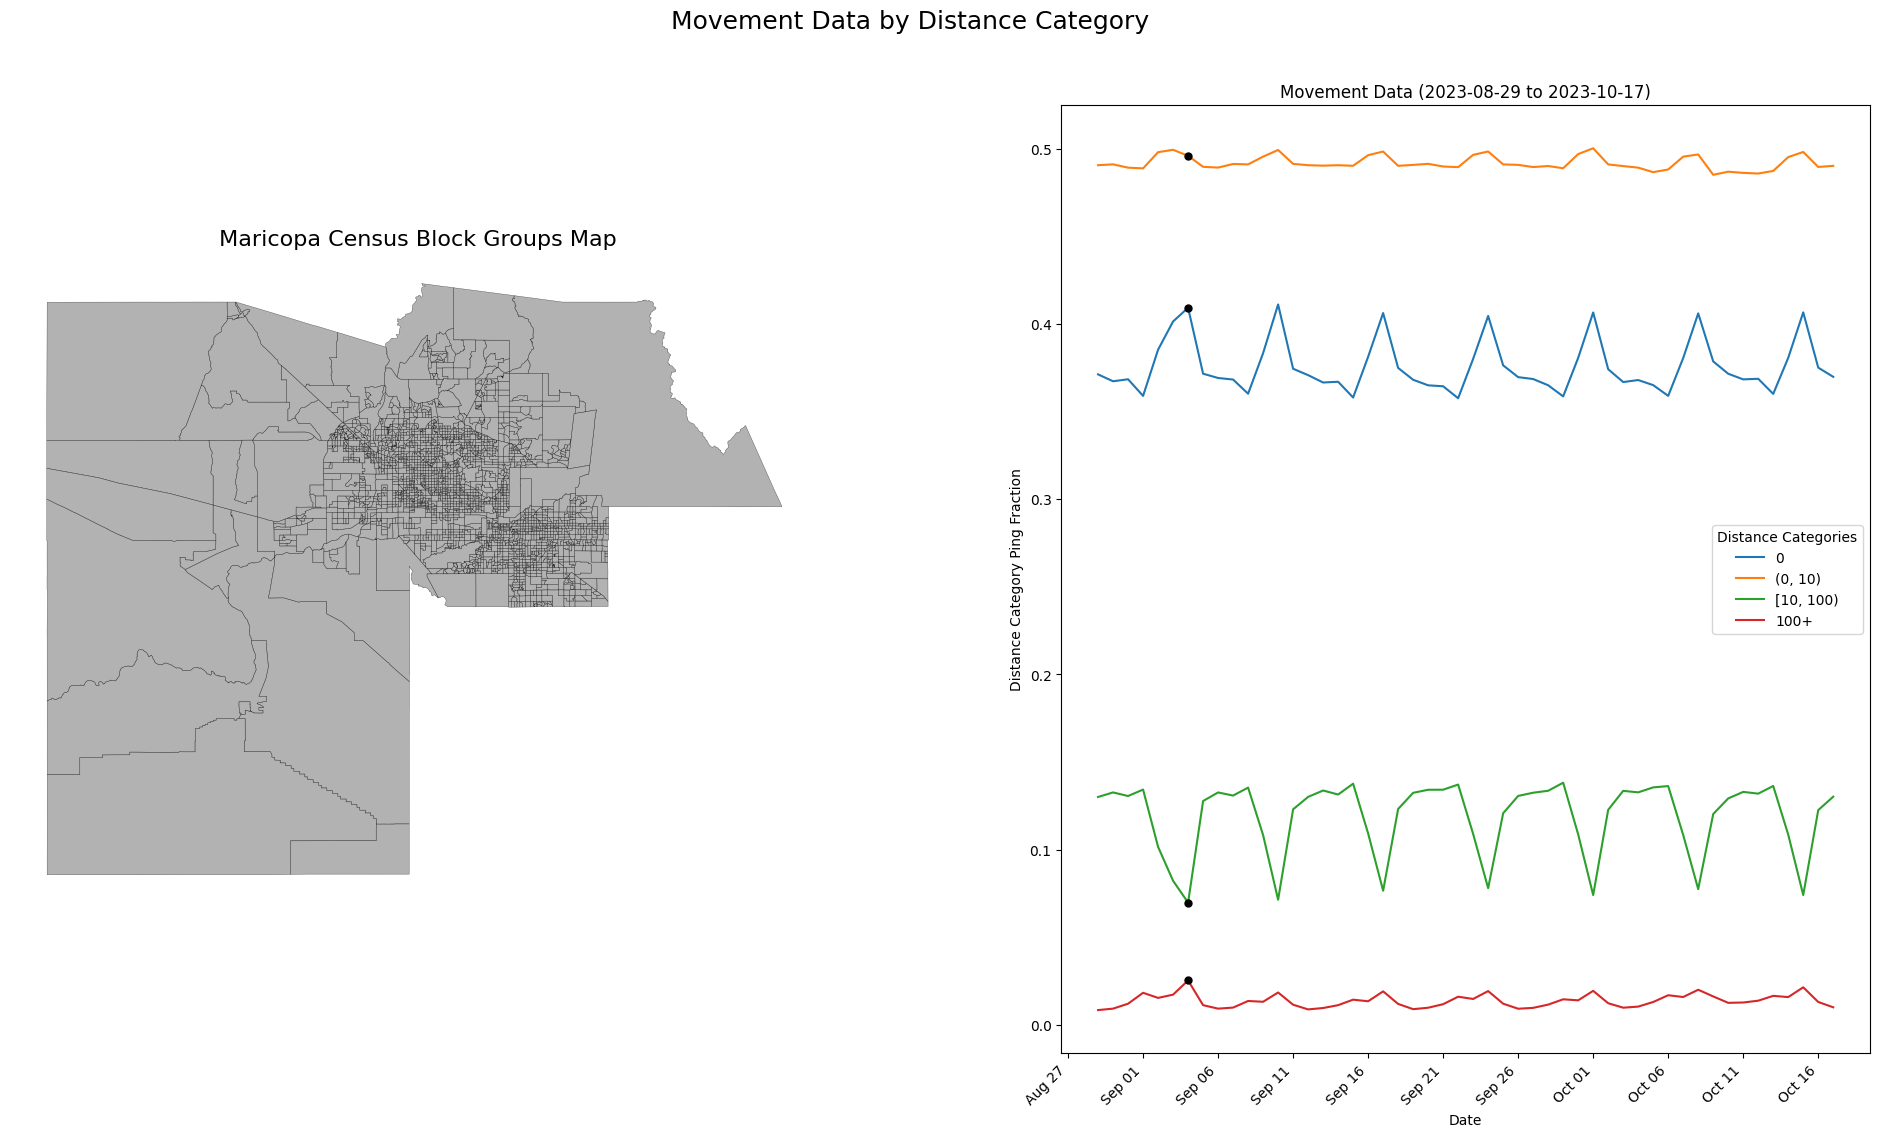

In [15]:
pivot_data["ds"] = pd.to_datetime(pivot_data["ds"], errors='coerce')
pivot_data = pivot_data.dropna(subset=["ds"])

start_date_graph = pd.to_datetime("2023-08-29")
end_date_graph = start_date_graph + pd.Timedelta(days=49)
filtered_pivot_data = pivot_data[
    (pivot_data["ds"] >= start_date_graph) & (pivot_data["ds"] <= end_date_graph)
]

filtered_holiday_dates = [d for d in holiday_dates if start_date_graph <= d <= end_date_graph]

fig = plt.figure(figsize=(24, 12))
gs = fig.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)

ax_map = fig.add_subplot(gs[0])
census_block_groups.plot(
    linewidth=0.3, ax=ax_map, edgecolor="black", color="grey", alpha=0.6
)
ax_map.axis("off")
ax_map.set_title(f"{County} Census Block Groups Map", fontsize=16)


ax_graph = fig.add_subplot(gs[1])
x = filtered_pivot_data["ds"]
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

for i, category in enumerate(required_categories):
    ax_graph.plot(x, filtered_pivot_data[category], label=category, color=colors[i])

for holiday in filtered_holiday_dates:
    for i, category in enumerate(required_categories):
        holiday_value = filtered_pivot_data.loc[filtered_pivot_data["ds"] == holiday, category].values
        if len(holiday_value) > 0:
            ax_graph.plot(holiday, holiday_value[0], "ko", markersize=5)

ax_graph.set_ylabel("Distance Category Ping Fraction")
ax_graph.set_xlabel("Date")
ax_graph.legend(title="Distance Categories")
ax_graph.xaxis.set_major_locator(mdates.DayLocator(interval=5))
ax_graph.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.setp(ax_graph.get_xticklabels(), rotation=45, ha="right")
ax_graph.set_title(f"Movement Data ({start_date_graph.date()} to {end_date_graph.date()})")

fig.suptitle(f"Movement Data by Distance Category", fontsize=18)
plt.subplots_adjust(top=0.9)
plt.show()

# Lodes Communter Matrix


In [6]:
az_lodes_od = get_lodes(state="AZ", year=2019, lodes_type="od", cache=True)

target_blockgroup = "040131084002"  # Replace with your target workplace block group FIPS

apple = (
    az_lodes_od.assign(
        w_BlockGroup=az_lodes_od["w_geocode"].str.slice(stop=12),
        h_BlockGroup=az_lodes_od["h_geocode"].str.slice(stop=12),
    )
    .query('w_BlockGroup == @target_blockgroup')
    .groupby("h_BlockGroup", as_index=False)
    .agg({"S000": "sum"})
    .rename({"S000": "apple_workers"}, axis=1)
)

apple_commuters = (
    az_lodes_od
    .assign(h_BlockGroup=az_lodes_od['h_geocode'].str.slice(stop=12))
    .groupby('h_BlockGroup', as_index=False)
    .agg({'S000': "sum"})
    .rename({'S000': 'total_workers'}, axis=1)
    .merge(apple, on='h_BlockGroup', how='left')
    .fillna({'apple_workers': 0})
    .assign(apple_per_1000=lambda x: 1000 * (x['apple_workers'] / x['total_workers']))
)


maricopa_bgs = block_groups(
    state="04",  
    county="013",  
    cb=True,
    year=2019,
    cache=True,
)

# Merge the commuting data with the spatial data
merged = maricopa_bgs.merge(
    apple_commuters, how="left", left_on="GEOID", right_on="h_BlockGroup"
).fillna({"apple_workers": 0, "total_workers": 0, "apple_per_1000": 0})

In [13]:
LODES_rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["LODES"](),
    scope=scope,
    params={
        "beta": 0.35,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 10.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 50),
    init=init.SingleLocation(location=0, seed_size=5),
)

LODES_sim = BasicSimulator(LODES_rume)
with sim_messaging():
    LODES_output = LODES_sim.run()

ADRIO Population fetching `gpm:all::mm::population`...ADRIO Population fetching `gpm:all::mm::population`...ADRIO Population fetching `gpm:all::mm::population`... done (0.000 seconds)
 done (0.000 seconds)
 done (0.000 seconds)
ADRIO GeometricCentroid fetching `gpm:all::mm::centroid`...ADRIO GeometricCentroid fetching `gpm:all::mm::centroid`...ADRIO GeometricCentroid fetching `gpm:all::mm::centroid`... done (79.134 seconds)
 done (79.134 seconds)
 done (79.134 seconds)
ADRIO Population fetching `gpm:all::init::population`...ADRIO Population fetching `gpm:all::init::population`...ADRIO Population fetching `gpm:all::init::population`... done (0.000 seconds)
 done (0.000 seconds)
 done (0.000 seconds)
ADRIO Name fetching `meta::geo::label`...ADRIO Name fetching `meta::geo::label`...ADRIO Name fetching `meta::geo::label`... done (0.113 seconds)
 done (0.113 seconds)
 done (0.113 seconds)
Running simulation (BasicSimulator):
• 2020-01-01 to 2020-02-20 (50 days)
• 2505 geo nodes
Running simu

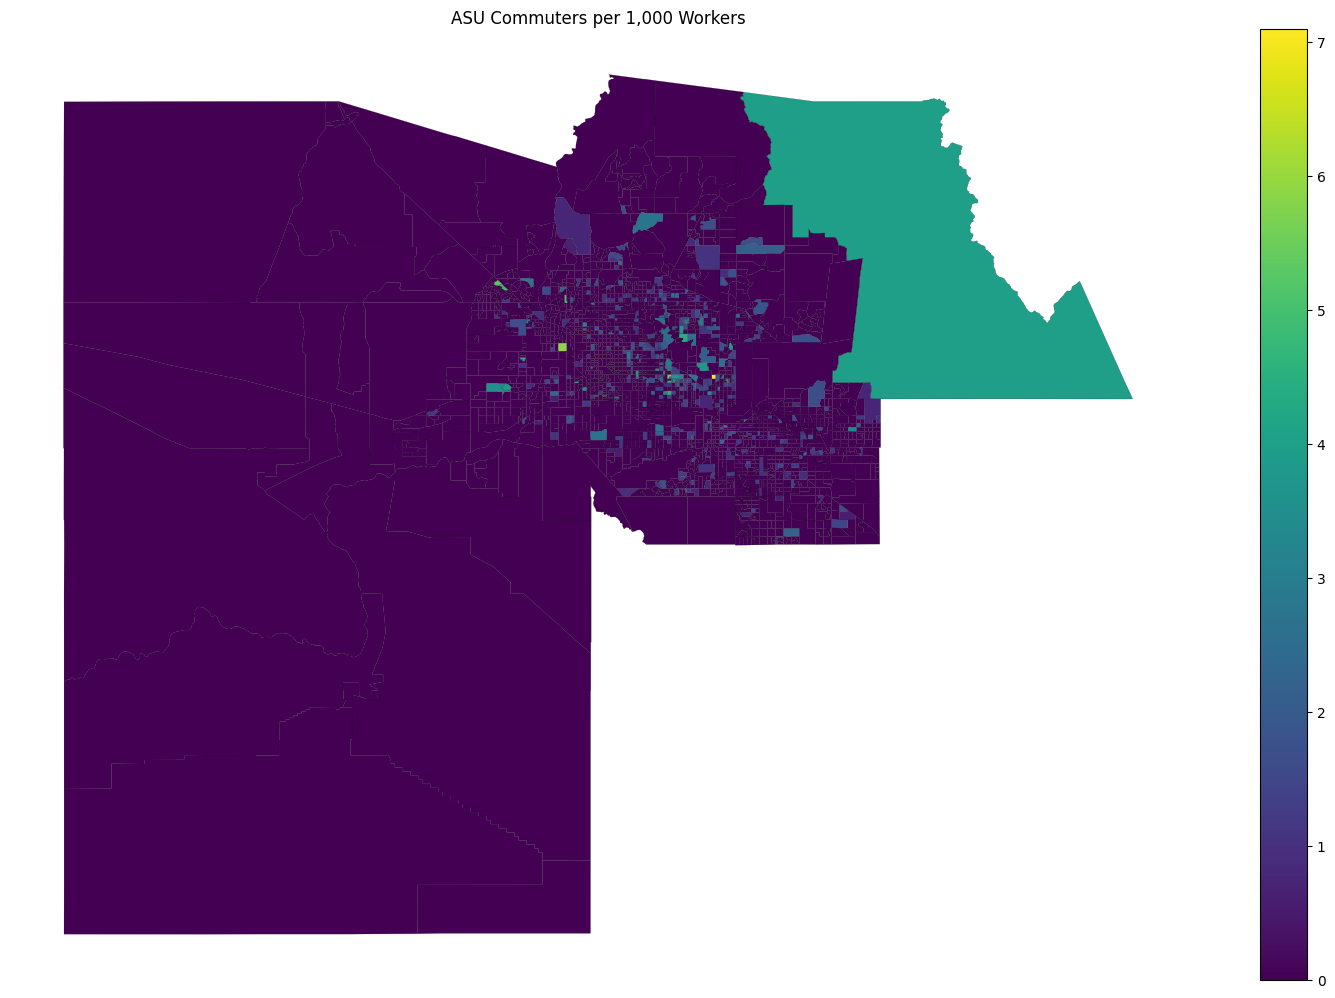

In [8]:
fig, ax2 = plt.subplots(figsize=(15, 10))  # Only one axis now

merged.plot(
    column="apple_per_1000",
    ax=ax2,
    legend=True,
    cmap="viridis",
    edgecolor="black",
    linewidth=0.1,
)
ax2.set_title("ASU Commuters per 1,000 Workers")
ax2.axis("off")

plt.tight_layout()
plt.show()


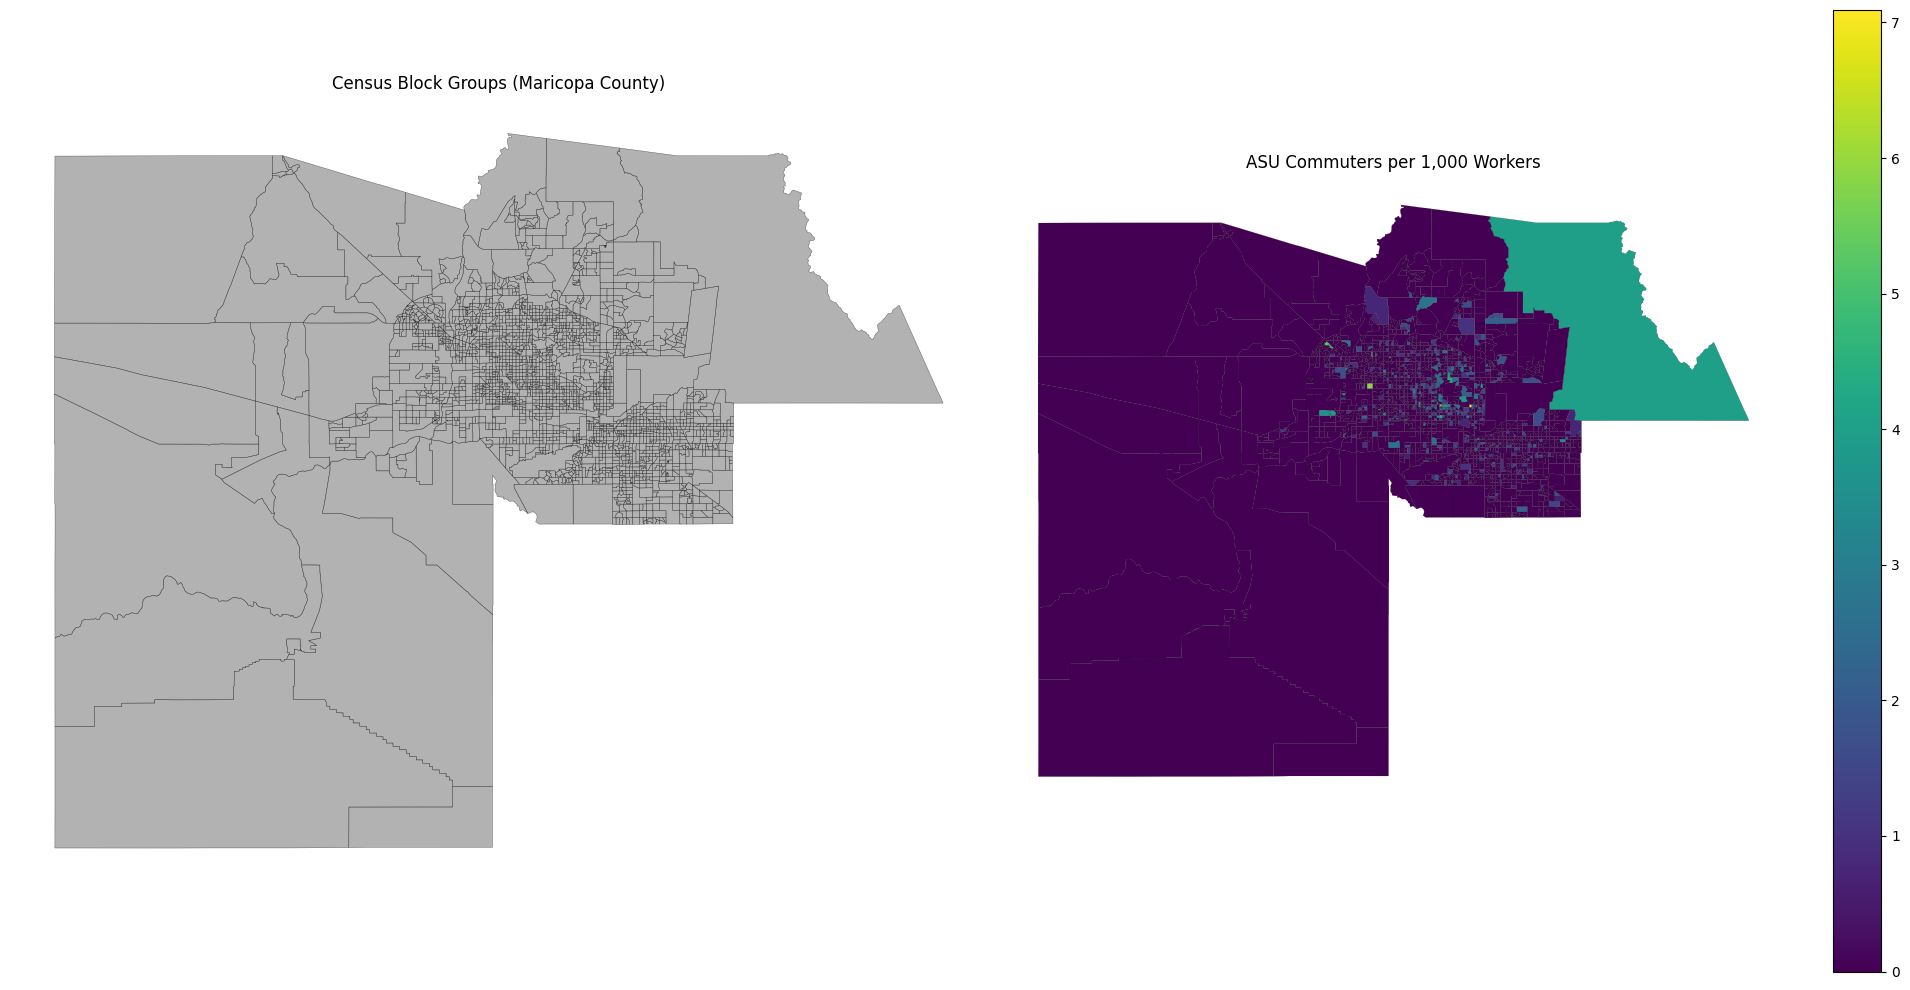

In [30]:
day_of_peak_infection = np.array(
    [
        # argmax gives us an index, but the index is equal to the tau step index
        # so just need to floor-div by number of tau steps to get day
        float(np.argmax(LODES_output.incidence[:, n, EVENT_S_TO_I]))
        // LODES_output.dim.tau_steps
        for n in range(scope.nodes)
    ]
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  

census_block_groups.plot(
    linewidth=0.3,
    ax=ax1,
    edgecolor="black",
    color="grey",
    alpha=0.6
)
ax1.axis("off")
ax1.set_title("Census Block Groups (Maricopa County)")

merged.plot(
    column="apple_per_1000",
    ax=ax2,
    legend=True,
    cmap="viridis",
    edgecolor="black",
    linewidth=0.1,
)
ax2.set_title("ASU Commuters per 1,000 Workers")
ax2.axis("off")

plt.tight_layout()
plt.show()


# School Communter Matrix


In [ ]:
census_block_groups = block_groups(state=STATE, county=COUNTY, year=YEAR, cb=True, cache=True)
districts = school_districts(state=STATE, year=YEAR, cache=True)

maricopa_district_names = [
    "Phoenix Union High School District",
    "Tempe Union High School District",
    "Mesa Unified District",
    "Chandler Unified District",
    "Scottsdale Unified District",
    "Gilbert Unified District",
    "Peoria Unified District",
    "Deer Valley Unified District",
    "Glendale Elementary District",
    "Paradise Valley Unified District",
    "Kyrene Elementary District",
    "Tolleson Union High School District",
    "Cartwright Elementary District",
    "Avondale Elementary District",
    "Litchfield Elementary District",
]

districts_maricopa = districts[districts["NAME"].isin(maricopa_district_names)]

districts_maricopa = districts_maricopa.to_crs(census_block_groups.crs)

In [ ]:
School_rume = SingleStrataRume.build(
    ipm=ipm_library["sirh"](),
    mm=mm_library["School"](),
    scope=scope,
    params={
        "beta": 0.35,
        "gamma": 0.25,
        "xi": 0.0111,
        "hospitalization_prob": 0.1,
        "hospitalization_duration": 7.0,
        "phi": 10.0,
        "population": acs5.Population(),
        "centroid": us_tiger.GeometricCentroid(),
        "meta::geo::label": us_tiger.Name(),
    },
    time_frame=TimeFrame.of("2020-01-01", 150),
    init=init.SingleLocation(location=0, seed_size=5),
)

School_sim = BasicSimulator(School_rume)
with sim_messaging():
    School_output = School_sim.run()

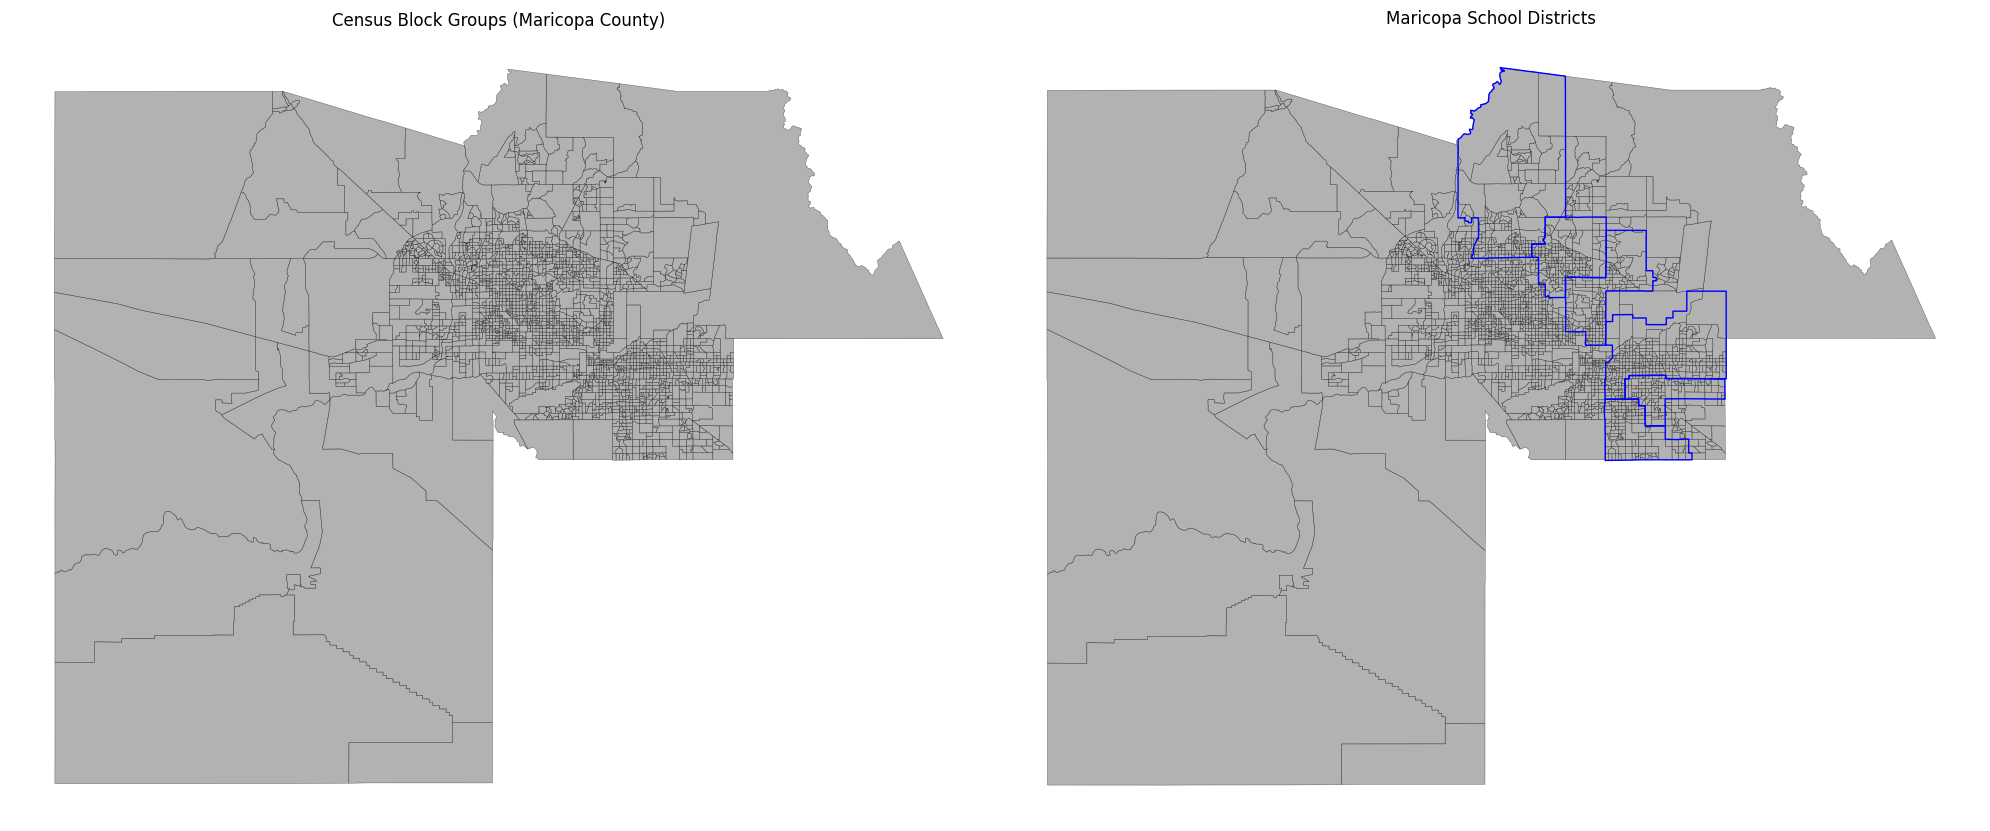

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

census_block_groups.plot(
    linewidth=0.3,
    ax=ax1,
    edgecolor="black",
    color="grey",
    alpha=0.6
)
ax1.axis("off")
ax1.set_title("Census Block Groups (Maricopa County)")

census_block_groups.plot(
    linewidth=0.3,
    ax=ax2,
    edgecolor="black",
    color="grey",
    alpha=0.6
)
districts_maricopa.plot(
    linewidth=1,
    ax=ax2,
    edgecolor="blue",
    facecolor="none"
)
ax2.axis("off")
ax2.set_title("Maricopa School Districts")

plt.tight_layout()
plt.show()